# NMF Practical Work

**Roland Badeau - Notebook code by Umut Simsekli** 

Telecom Paris - TSIA 206

In [54]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display


C:\Users\jeann\AppData\Local\Temp\ipykernel_7080\1574094465.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  ms.use('seaborn-muted')


<Figure size 640x480 with 0 Axes>

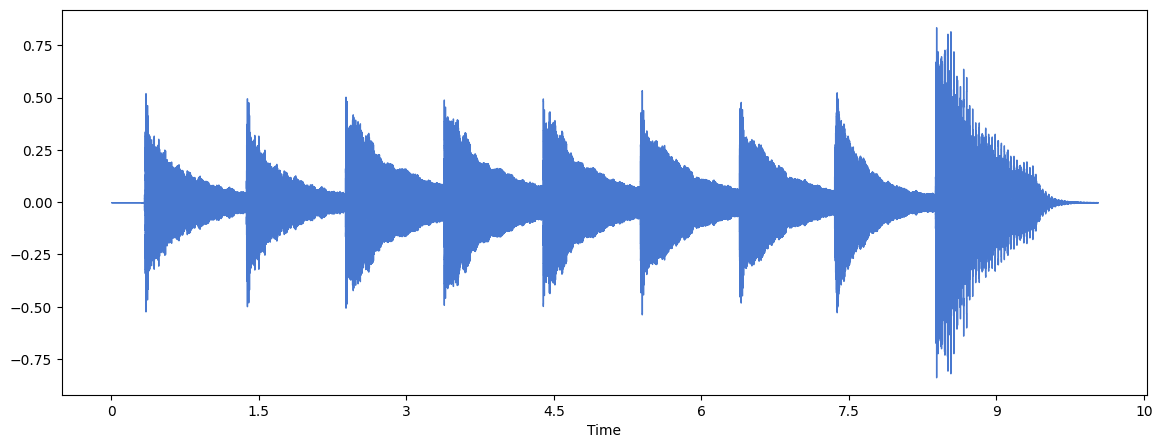

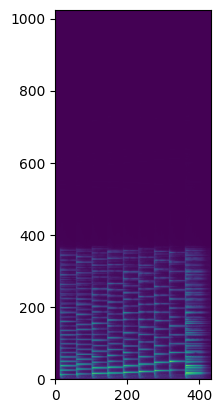

In [55]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


#### 1. MUR algorithm derivation


We try to minimize the following expression, with $W, H \geq 0$ :

$$
\begin{align}
∥V−WH∥^2_F &= Tr((V−WH)^T(V−WH))\\
&= Tr((V^T−H^TW^T)(V−WH))\\
&= Tr(V^TV−V^TWH−H^TW^TV+H^TW^TWH)\\
&= Tr(V^TV)−Tr(V^TWH)−Tr(H^TW^TV)+Tr(H^TW^TWH)\\
\end{align}
$$

It is now easy to derivate each term with respect to $W$ and $H$.

$\begin{align}
∇_WTr(V^TV)&=0
\end{align}$

$\begin{align}
∇_WTr(V^TWH)&=∇_WTr(HV^TW)\\
&=(HV^T)^T \\
&=VH^T\\
\end{align}$

$\begin{align}
∇_WTr(H^TW^TV)&=∇_WTr(VH^TW^T)\\
&=VH^T
\end{align}$

$\begin{align}
∇_WTr(H^TW^TWH)&=∇_WTr(WHH^TW^T)\\
&=∇_W∥WH∥^2_F\\
&=2W∥H∥^2_F\\
&=2WHH^T
\end{align}$

We can do the same for $H$.
By setting $f_V(W,H)=∥V−WH∥^2_F$, we can write the following update rules:

$$∇_Wf_V(W,H)=−2VH^T+2WHH^T \\  

∇_Hf_V(W,H)=−2W^TV+2W^TWH
$$

In [56]:
# Implement MUR for NMF with beta-divergence 

def beta_div(X, W, H, beta):
    X_hat = np.matmul(W, H)
    cost = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = X[i, j]; 
            x_hat = X_hat[i, j]
            cost += x**beta/(beta*(beta-1)) - x*x_hat**(beta-1)/(beta-1) + x_hat**beta/beta
    return cost

def MUR(X, K, beta=1, iter=100, epsilon=0.0001):
    F,T = X.shape
    
    W = np.random.rand(F,K)
    np.where(W!=0, W, 0.0001) 
    print(W)
    H = np.random.rand(K,T)
    np.where(H!=0, H, 0.0001)
    
    cost = np.inf
    costs = []

    for i in range(iter):
        if cost < epsilon :
            break

        # Updating W
        X_hat = np.matmul(W,H)
        W = np.multiply(W, (np.multiply(X, (X_hat+1e-10)**(beta-2))@H.T)/((X_hat+1e-10)**(beta-1)@H.T))
        
        # Updating H
        X_hat = np.matmul(W,H)
        H = np.multiply(H, (W.T@np.multiply(X, (X_hat+1e-10)**(beta-2)))/(W.T@(X_hat+1e-10)**(beta-1)))

        cost = beta_div(X, W, H, beta)
        costs.append(cost)

    return W, H, costs
    

In [61]:
K=10
beta = 2

W, H, costs = MUR(X, beta, K, iter=25)

[[0.14579417 0.4179411 ]
 [0.12500186 0.37439838]
 [0.44787224 0.31311449]
 ...
 [0.95345693 0.75421333]
 [0.02526583 0.68223908]
 [0.54521469 0.93891238]]


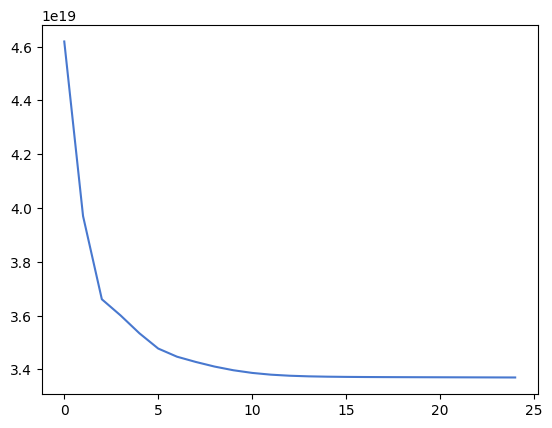

In [62]:
plt.plot(costs)

In [63]:
# Use Wiener filtering to reconstruct each note separately
def reconstruct_wien(X, W, H, note):
    X_hat = np.matmul(W, H) + 1e-10
    X_hat_note = np.matmul(W[:, note].reshape(-1, 1), H[note, :].reshape(1, -1))
    return X*X_hat_note/X_hat
# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)


In [64]:
X_reconstructed = 0
for k in range (K):
    X_reconstructed += reconstruct_wien(Xstft, W, H, k)
y_reconstructed = librosa.istft(X_reconstructed)
ipd.Audio(y_reconstructed, rate=sr)

IndexError: index 2 is out of bounds for axis 1 with size 2